# Unconstrained optimization (part 2)

In [1]:
import numpy as np
import numpy.linalg as la
import scipy
import scipy.sparse
import scipy.sparse.linalg
import scipy.optimize
import matplotlib.pyplot as plt

## Background: Linear least squares

The *linear* least squares problem is
$$
  \min_{x \in \mathbb{R}^n} \frac{1}{2} \|Ax-b\|^2
$$
where $A \in \mathbb{R}^{m \times n}$ with $m > n$.  This is a quadratic optimization problem, so the stationary equation is just a linear system (the so-called *normal equations*):
$$
  A^T (Ax-b) = 0.
$$
The problem has a unique solution so long as $A$ has rank $n$.
In this case, the solution is sometimes written as
$$
  x = A^\dagger b = (A^T A)^{-1} A^T b
$$
where $A^\dagger$ is the (Moore-Penrose) pseudoinverse of $A$.
We usually do not form the normal equations explicitly, but rather use specialized solvers to solve the least squares problem (using QR factorization, for example).  You can access these solvers in Python via [`numpy.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html),
which  uses an SVD-based solver.

As an example, let's consider solving the function approximation
$$
  \min_{u \in \mathcal{P}^6} \int_{-1}^1 |u(x) - \exp(-x^2)|^2 \, dx.
$$
We can actually compute the integrals needed to do this in closed form, but we'll instead
discretize via the composite midpoint rule with $N$ panels, solving
$$
  \min_{u \in \mathcal{P}^6} \frac{1}{N} \sum_{j=1}^N |u(x_j)-\exp(-x_j^2)|^2.
$$
where the $x_j$ are the quadrature nodes at the midpoint of each panel.

Coefficient vector: [ 0.99984979 -0.99444393  0.46802665 -0.10604777]
Singular values: [34.69950337 13.22176295  2.76656609  0.34309204]


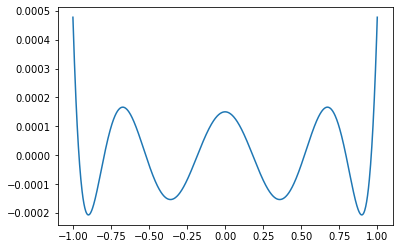

In [2]:
# Example: Best degree 6 poly approximation to exp(-x^2) on [-1,1] in an L^2 sense
# Discretize using composite midpoint rule

xx = np.linspace(-1,1, 1000)
xs = (xx[:-1] + xx[1:])/2
A = np.array([xs*0+1, xs**2, xs**4, xs**6]).T
b = np.exp(-xs**2)
x, resid, rank, svs = la.lstsq(A, b, rcond=None)

print("Coefficient vector: {0}".format(x))
print("Singular values: {0}".format(svs))
plt.plot(xs, np.exp(-xs**2) - A@x)

More generally, if $M$ is a positive definite weight matrix, the weighted least squares problem is
$$
  \min_{x \in \mathbb{R}^n} \frac{1}{2} (Ax-b)^T M (Ax-b).
$$
The normal equations for the weighted problem are
$$
  A^T M (Ax-b) = 0.
$$
The weighted problem may be rewritten as an ordinary least squares problem via a Cholesky factorization $M = R^T R$:
$$
  \min_{x \in \mathbb{R}^n} \frac{1}{2} \|R(Ax-b)\|^2.
$$
The most common version of weighted least squares uses a diagonal $M$ matrix.

Let's illustrate by considering the same function approximation problem
$$
  \min_{u \in \mathcal{P}^6} \int_{-1}^1 |u(x) - \exp(-x^2)|^2 \, dx.
$$
This time, we'll discretize via Gauss quadrature, solving
$$
  \min_{u \in \mathcal{P}^6} \sum_{j=1}^N w_j |u(x_j)-\exp(-x_j^2)|^2.
$$
where the $x_j$ are the quadrature nodes and $w_j$ are the quadrature weights.

Coefficient vector: [ 0.99984978 -0.99444363  0.46802561 -0.1060469 ]
Singular values: [1.55258636 0.59159498 0.12378883 0.01535179]


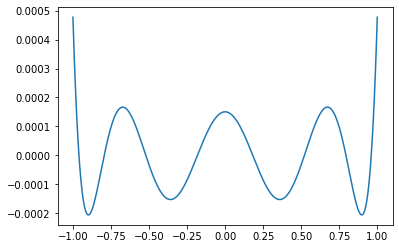

In [3]:
# Example: Best degree 6 poly approximation to exp(-x^2) on [-1,1] in an L^2 sense
# Discretizee using Gauss quadrature

# Gauss quadrature nodes and weights for (degreee 13 rule)
xgauss = np.array(
    [0.0000000000000000, -0.2304583159551348,  0.2304583159551348, -0.4484927510364469,  0.4484927510364469,\
    -0.6423493394403402,  0.6423493394403402, -0.8015780907333099,  0.8015780907333099, -0.9175983992229779,\
     0.9175983992229779, -0.9841830547185881,  0.9841830547185881])
wgauss = np.array(
    [0.2325515532308739, 0.2262831802628972, 0.2262831802628972, 0.2078160475368885, 0.2078160475368885,\
     0.1781459807619457, 0.1781459807619457, 0.1388735102197872, 0.1388735102197872, 0.0921214998377285,\
     0.0921214998377285, 0.0404840047653159, 0.0404840047653159])

w = np.sqrt(wgauss)
A = np.array([w*(xgauss*0+1), w*(xgauss**2), w*(xgauss**4), w*(xgauss**6)]).T
b = w*np.exp(-xgauss**2)

x, resid, rank, svs = la.lstsq(A, b, rcond=None)

print("Coefficient vector: {0}".format(x))
print("Singular values: {0}".format(svs))
Aplt = np.array([xs*0+1, xs**2, xs**4, xs**6]).T
plt.plot(xs, np.exp(-xs**2) - Aplt@x)

## Regularized linear least squares

The least squares problem is ill-conditioned (or ill-posed) when $\kappa(A) = \sqrt{\kappa(A^T A)}$ is large.  This frequently happens in statistical applications when the columns of $A$ correspond to measured factors that are highly correlated.  In this case, there are many linear models that fit the data about equally well, and one needs a principled way to choose among them.  Just fitting the data results in "overfitting" phenomena in which the exact model chosen is very sensitive to noise in the data; usually the resulting models generalize poorly.  To balance the data fidelity against what we expect in a "good" model, we *regularize* the problem.  A common regularization strategy is to seek models for which the coefficients are not too large.  This leads to *Tikhonov regularization*:
$$
  \min_{x} \frac{1}{2} \|Ax-b\|^2 + \frac{\mu}{2} \|x\|^2,
$$
for which the corresponding stationary equations are
$$
  (A^T A + \mu I) x = A^T b.
$$
We can also encode this in an ordinary least squares problem as
$$
  \min_{x} \frac{1}{2} \left\| \begin{bmatrix} A \\ \sqrt{\mu} I \end{bmatrix} x - \begin{bmatrix} b \\ 0 \end{bmatrix} \right\|^2.
$$
The regularization parameter $\mu$ has to be chosen carefully according to the properties of the noise.  Note that if $A$ is exactly singular, the limit as $\mu \rightarrow 0$ gives the minimal norm solution such that the residual is minimal.

Closely related to the Tikhonov regularization problem is the problem of computing
$$
  \min_{x} \frac{1}{2} \|Ax-b\|^2 \mbox{ s.t. } \|x\| \leq \rho.
$$
In this case, the (constrained) stationary conditions (or KKT conditions) are
$$\begin{align*}
  (A^T A + \mu I) x &= A^T b \\
  \mu & \geq 0 \\
  \|x\| &\leq \rho \\
  \mu (\|x\|-\rho) &= 0
\end{align*}$$
The first of these equations is just the usual Tikhonov-regularized normal equations, except that the regularization parameter $\mu$ here is re-cast as a Lagrange multiplier.

Just as we can incorporate scaling matrices into the least squares objective, we can also incorporate scaling into the regularization term.  This task is left to the reader.

## Nonlinear least squares

The nonlinear least squares problem is
$$
  \min_{x \in \Omega} \frac{1}{2} \|f(x)\|^2
$$
where $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$.  Let $J(x)$ denote the Jacobian matrix for $f(x)$.
Then the stationary equation $\nabla \phi(x) = 0$ is
$$
  J(x)^T f(x) = 0.
$$
For a linear $f$ ($f(x) = Ax-b$), these stationary equations are just the usual normal equations.

In stellarator optimization problems, the tradeoff between different objectives is often encoded as a weighted nonlinear least squares problem (this is the strategy used in the STELLOPT and ROSE packages):
$$
  \chi^2(x) = \sum_k \sigma_k^{-2} (F_k(x)-F_k^*)^2,
$$
where $F_k(x)$ is a quantity of interest and $F_k^*$ is a target value.

As an aside, we note that we have already computed the sensitivity of optima with respect to small changes in the previous lecture.  This could in principle be used to compute the sensitivity of an optimum to changes in weights, at least if one had the right derivative computations available.

## The shortfalls of scalarization

The nonlinear least squares problem in STELLOPT and ROSE is a special case of a general approach to multi-objective optimization known as *scalarization*.  The idea is that if we want to minimize $g_1(x), g_2(x), \ldots, g_m(x)$, we try minimizing the single objective
$$
  \phi(x) = \sum_{k=1}^m w_j g_j(x).
$$
Then we can modify the weights $w$ in order to explore the Pareto frontier (the set of "optimal" solutions in the sense that no other solution is better in all $m$ objectives).  However, this approach has two major issues:

- Unless the Pareto frontier is convex, not every Pareto-optimal point is the solution of a scalarized problem (though every Pareto-optimal point does turn out to be a *stationary point* for a scalarized problem).
- Even in the convex frontier case, uniformly varying the weights may yield a very non-uniform sampling of the Pareto frontier.

A nice dicusssion of the shortcomings of the scalarization approach is provided in Das and Dennis, ["A closer look at drawbacks of minimizing weighted sums of objectives for Pareto set generation in multicriteria optimization problems"](https://dx.doi,org/10.1007/BF01197559), *Structural Optimization* 14, 63–69 (1997), the last sentence of which reads:

> The chief role of this paper is to caution people who blindly lump several objectives into one using a weighted combination and the authors hope to have accomplished that.

Having duly noted this caution, we proceed with our discussion of nonlinear least squares algorithms.

## Gauss-Newton algorithm

Having warned about the shortcomings of a $\chi^2$ scalarization as a way of solving multi-objective optimization problems, we now discuss algorithms for solving the problem.

The Hessian for $\phi(x) = \|f(x)\|^2/2$ is
$$
  H_{\phi}(x) = J(x)^T J(x) + \sum_{i=1}^m f_i(x) H_{f_i}(x)
$$
When we can actually achieve a small residual (i.e. $\|f(x_*)\|$ is small at the optimum), it seems reasonable to neglect the latter part of the Hessian.  Plugging this approximate Hessian into our Newton iteration gives the *Gauss-Newton* iteration
$$
  x_{k+1} = x_k - \left[ J(x)^T J(x) \right]^{-1} J(x)^T f(x) = x_{k} - J(x)^\dagger f(x).
$$
This is equivalent to computing $x_{k+1} = x_k + p_k$ with
$$
  p_k = \mbox{argmin}_{p} \frac{1}{2} \|f(x) + J(x) p\|^2.
$$
That is, at every step we solve a linear least squares problem for the update.  Indeed, another way to think about the same iteration is that it is based on using a linear model of $f$ at each step.

[1.00509257 0.5436109  0.67403337]


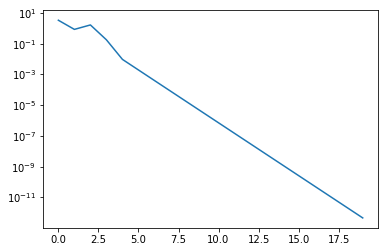

In [4]:
# Example: fit a Lorentzian
def lorentzian(x, beta):
    "Evaluate the Lorentzian with params beta at x"
    z = (x-beta[1])/beta[2]
    return beta[0]/(1 + z**2)

def dlorentzian(x, beta):
    "Gradient of the Lorentzian with respect to params beta at x"
    z = (x-beta[1])/beta[2]
    dz1 = -1/beta[1]
    dz2 = -z/beta[2]
    c = -beta[0]*2*z/(1 + z**2)**2
    return np.array([1/(1 + z**2), c*dz1, c*dz2])

def Jlorentzian(xx, beta):
    "Return dlorentzian with respect to beta at many x"
    return np.array([dlorentzian(x, beta) for x in xx])

# Set up a noisy signal
beta_ref = [1.0, 0.5, 0.7]
xs = np.linspace(0, 3, 20)
fnoisy = lorentzian(xs, beta_ref) + np.random.normal(scale=1e-1, size=(20,))

# Gauss-Newton iteration
beta = [1.0, 1.0, 1.0]
resids = []
for k in range(20):
    J = Jlorentzian(xs, beta)
    f = lorentzian(xs, beta)-fnoisy
    resids.append(la.norm(J.T @ f))
    p = la.lstsq(J, f, rcond=None)[0]
    beta -= p

print(beta)
plt.plot(resids)
plt.yscale("log")

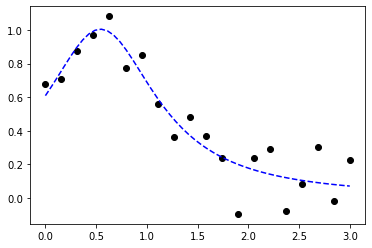

In [5]:
xx = np.linspace(0, 3)
plt.plot(xs, fnoisy, 'ko', xx, lorentzian(xx, beta), 'b--')

## Levenberg-Marquardt and trust regions

Gauss-Newton iteration chooses descent directions, and when $\|f(x_*)\|$ is nearly zero it often converges quite quickly.  In general, though, Gauss-Newton without line search is not guaranteed to converge at all, even from very good initial guesses.  In particular, it does not work well when the Jacobian is ill-conditioned.  The Levenberg-Marquardt scheme deals with this issue by solving a regularized least squares problem at each step:
$$
  x_{k+1} = x_k - \left[ J(x_k)^T J(x_k) + \lambda_k I\right]^{-1} J(x_k)^T f(x_k).
$$
The parameter $\lambda_k$ may be dynamically adjusted during the optimization process.  When $\lambda$ is relatively large, the update is close to a gradient descent step with a small step size; when $\lambda$ is zero, we have a Gauss-Newton step.

Though the Levenberg-Marquardt algorithm was originally discussed in the language of regularization, researchers later realized that one could think about the parameter $\lambda_k$ as a Lagrange multiplier enforcing the condition that the step should minimize the least squares model while remaining inside some "trust region" where the model was deemed trustworthy.  Moreover, the trust region idea applies equally well to more general optimization problems, and is one of the most common globalization strategies in common use.  Though trust-region Newton (and Newton-like) methods are slightly more complex than methods with line search, they also converge faster on a variety of problems.  The [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) routine includes several trust-region based methods, as does the
[`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) routine.

In [6]:
result = scipy.optimize.least_squares(lambda beta: lorentzian(xs, beta)-fnoisy, [1.0, 1.0, 1.0],
                                      jac=lambda beta: Jlorentzian(xs, beta), method='lm')
print(result)

 active_mask: array([0, 0, 0])
        cost: 0.15307735396550257
         fun: array([-0.06908752,  0.04651342,  0.02544659,  0.02117956, -0.0938562 ,
        0.1111675 , -0.11179986,  0.0355183 ,  0.10499727, -0.1078576 ,
       -0.07219252,  0.00710365,  0.29589197, -0.07262682, -0.14964927,
        0.19837177,  0.01985503, -0.21436915,  0.09885279, -0.15678313])
        grad: array([-9.01197817e-07, -7.70254966e-06, -1.18665309e-06])
         jac: array([[ 0.60589675, -1.09484243,  0.7121361 ],
       [ 0.75331332, -1.20083958,  0.55421173],
       [ 0.89747194, -1.00670298,  0.27442139],
       [ 0.98935219, -0.37549593,  0.03141707],
       [ 0.98325203,  0.46658095,  0.04911129],
       [ 0.8825709 ,  1.05065698,  0.30908627],
       [ 0.735931  ,  1.1996734 ,  0.57957399],
       [ 0.59019961,  1.07332992,  0.72131614],
       [ 0.46737481,  0.8622982 ,  0.74240583],
       [ 0.37110872,  0.66296134,  0.69603503],
       [ 0.29767262,  0.50329987,  0.62349483],
       [ 0.241901

## Models without derivatives

The methods we have discussed so far follow a common pattern:

- Build a model of the problem (accurate to at least first order) near the current point
- Follow the model downhill to a minimum
- Globalize the algorithm by not trusting the model too far away

We have thus far been building models based on Taylor expansions out to first order; an accurate Hessian is a nice bonus, but not strictly needed.  However, we do not need derivatives to follow this recipe!  We can equally well use models based on interpolation or regression.  Nor do we need to restrict our attention to linear and quadratic models, as we will discuss.

It is worth mentioning at this point that, apart from helping us decide where to step next, gradient information plays another important role: it tells us about convergence.  Derivative free methods with a robust local convergence theory usually end up reconstructing derivatives close to the optimum, if only by interpolating through closely-spaced points.

### Finite-difference derivatives

The simplest approach to derivative-free optimization involves replacing gradients with finite-difference approximations.  As we discussed yesterday, this

- Requires many function evaluations for high-dimensional problems
- Requires care in choosing step sizes

We note that the (first-order) finite-difference approach basically involves replacing a model based on Taylor series with a corresponding model based on interpolating the function values that appear in the finite difference stencil.

Most of the derivative-based optimizers in `scipy.optimize.minimize` (as well as the solvers in `scipy.optimize.least_squares`) provide the option of using finite-difference derivatives.

### Other linear models

First-order finite difference approaches implicitly model the Taylor series up to first order via interpolation through $n+1$ function values obtained at points in a regular arrangement about the current guess.  But what if we choose $n+1$ function values from other locations -- for example, places that we previously sampled?  As long as the $n+1$ sample locations lie at the corners of a simplex with nonzero volume, the interpolation problem is well-posed (though we may need to be careful about simplices with poor aspect ratios).

There are many methods that implicitly use linear approximations based on interpolation over a simplex.  One that uses the concept rather explicitly is Powell's COBYLA (Constrained Optimization BY Linear Approximation), which combines a simplex-based linear approximation with a trust region.  COBYLA is one of the methods implemented in `scipy.optimize.minimize`.

### Quadratic models

One can build quadratic models of a function from only function
values, but to fit a quadratic model in $n$-dimensional space, we
usually need $(n+2)(n+1)/2$ function evaluations -- one for each of
the $n(n+1)/2$ distinct second partials, and $n+1$ for the linear
part.  Hence, purely function-based methods that use quadratic models
tend to be limited to low-dimensional spaces.  However, there are
exceptions.  The NEWUOA method (again by Powell) uses $2n+1$ samples
to build a quadratic model of the function with a diagonal matrix at
second order, and then updates that matrix on successive steps in a
Broyden-like way.  I believe this is the method labeled `powell` in
`scipy.optimize.minimize`.

### Kernel-based models

Polynomial approximations are useful, but they are far from the only
methods for approximating objective functions in high-dimensional
spaces.  One popular approach is to interpolate with *kernel functions*:
$$
  s(x) = \sum_{j=1}^m c_j k(x,x_j) + p(x)
$$
where $k$ is a *kernel function* and $p$ is a low-degree polynomial (usually at most linear),
chosen along with the coefficients $c_j$ to fit data at points $x_1, \ldots, x_{m+d}$,
either through interpolation or through regression.
Frequently, these kernel functions involve a *radial basis function* (RBF):
$k(x, y) = \phi(\|x-y\|)$.  RBF interpolants
are sometimes called splines; the polyharmonic RBF family has cubic
splines (1D) and thin-plate splines (2D) as special cases.  These models are
closely related to a family of statistical models known as Gaussian
processes (the fitting and predictions are identical for interpolation problems,
though the interpretation of the errors differs).

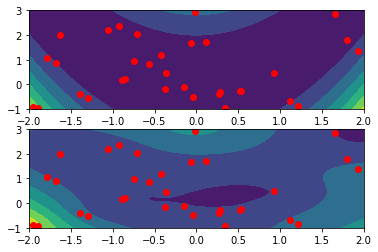

In [7]:
# Example: Approximation by thin-plate splines

def phi_tps(r):
    "Radial basis function for the thin-plate spline"
    if r > 0:
        return r**2 * np.log(r)
    else:
        return 0

def rosenbrock(x):
    "Rosenbrock banana function (standard optimization test)"
    return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

def rosenbrock_xy(x, y):
    return rosenbrock(np.array([x, y]))

# Form system matrix and rhs
N = 30
xs = 4 * np.random.uniform(size=(N+3,2))-np.array([2, 1])
K = np.zeros((N+3,N+3))
f = np.zeros(N+3)
for i in range(N):
    for j in range(N):
        K[i,j] = phi_tps(la.norm(xs[i,:]-xs[j,:]))
    K[i,N] = 1
    K[N,i] = 1
    K[i,N+1:] = xs[i,:]
    K[N+1:,i] = xs[i,:]
    f[i] = rosenbrock(xs[i,:])

c = la.solve(K, f)

def rosenbrock_approx(x):
    result = c[N] + c[N+1:].dot(x)
    for i in range(N):
        result += c[i] * phi_tps(la.norm(x-xs[i,:]))
    return result

def rosenbrock_approx_xy(x, y):
    return rosenbrock_approx(np.array([x, y]))

rosenbrock_approx_XY = np.frompyfunc(rosenbrock_approx_xy, 2, 1)

xx = np.linspace(-2, 2)
yy = np.linspace(-1, 3)
X, Y = np.meshgrid(xx, yy)
Z = rosenbrock_xy(X, Y)
Z_tps = rosenbrock_approx_XY(X, Y)

fig, axs=plt.subplots(2,1)
axs[0].contourf(X, Y, Z)
axs[0].plot(xs[:,0], xs[:,1], 'ro')
axs[1].contourf(X, Y, Z_tps)
axs[1].plot(xs[:,0], xs[:,1], 'ro')

Because kernel-based models may be more expensive to construct (and to
minimize) than are polynomial models, they are most often used for expensive
simulation-based objective functions.  Examples of local optimizers based on
kernel-based models include [ORBIT](https://www.mcs.anl.gov/papers/P1580.pdf)
for general problems and [POUNDERS](https://epubs.siam.org/doi/10.1137/1.9781611974683.ch40)
for nonlinear least squares problems. To my knowledge, there is no Python implementation of
ORBIT or POUNDERS, but there is an implementation of POUNDERS in
[PETSc/TAO](https://www.mcs.anl.gov/petsc/), and this has already been tried with
stellarator optimization via the [MANGO](https://github.com/hiddenSymmetries/mango)
interfaces developed by Matt Landreman as part of the SIMSOPT work.

### Response surfaces and global optimization

A *response surface* (or *surrogate model* or *meta-model*, depending on the context) is
an inexpensive approximation fit to sample evaluations from an expensive model.
Response surfaces may be polynomial models, kernel methods, neural networks, or any other
family that is relatively cheap to evaluate.

Response surfaces are a popular tool in *global* optimization.  *One-stage* optimizers
based on a response surface involve fitting a response surface to samples drawn from
some experimental design, then optimizing the response surface model instead of the
origiinal objective.  *Two-stage* methods subsequently enrich the model with additional
samples drawn to balance *exploration* (improving the model in previously under-sampled
parts of the search space) and *exploitation* (finding points that the model suggests
are good candidates for minimizers).

Perhaps the most popular response surface optimizers at
the moment are *Bayesian optimization* (BO) techniques, which are particularly popular in
machine learning.  BO methods often use Gaussian process models for the objective function,
which provide not only a prediction for the function but also a measure of uncertainty
in the prediction.  The prediction and the uncertainty are used together in an *acquisition function*
which is optimized to choose a next step.
The [BoTorch](https://botorch.org/) package out of Facebook Research
is a modern Python package that includes a variety of Bayesian optimization methods.

<a title="AnotherSamWilson / CC BY-SA (https://creativecommons.org/licenses/by-sa/4.0)" href="https://commons.wikimedia.org/wiki/File:GpParBayesAnimationSmall.gif"><img width="512" alt="GpParBayesAnimationSmall" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/GpParBayesAnimationSmall.gif/512px-GpParBayesAnimationSmall.gif"></a>

In many cases, these methods are much more sample efficient than alternatives
like simulated annealing or genetic algorithms.  But, as we have mentioned previously,
global optimization is hard.  A well-known theorem of [Torn and Zilinskas (1987)](https://www.springer.com/gp/book/9783540508717) says that for general continuous
functions, global convergence for global optimization problems requires dense sampling
in the space.  Response surfaces that incorporate some knowledge of the structure of
an objective (smoothness, symmetries, etc) are much more likely to achieve a good
outcome in a reasonable number of evaluations.  This is particularly true in
high-dimensional spaces.

## Pattern search and simplex

So far, the methods we have described are explicit in building a model
that approximates the function.  However, there are also methods that
use a systematic search procedure in which a model does not explicitly
appear.  These sometimes go under the heading of "direct search"
methods.

### Nelder-Mead

The Nelder-Mead algorithm is one of the most popular derivative-free
optimizers around.  For example, this is the default algorithm used
in MATLAB's `fminsearch`, as well as being one of the options in
`scipy.optimize.minimize`.  As with methods like COBYLA, the
Nelder-Mead approach maintains a simplex of $n+1$ function evaluation
points that it updates at each step.  In Nelder-Mead,
one updates the simplex based on function values at the simplex
corners, the centroid, and one other point; or one contracts the simplex.

Visualizations of Nelder-Mead are often quite striking: the simplex
appears to crawl downhill like some sort of mathematical amoeba.
But there are examples of functions where Nelder-Mead is not
guaranteed to converge to a minimum at all.

<a title="Nicoguaro / CC BY (https://creativecommons.org/licenses/by/4.0)" href="https://commons.wikimedia.org/wiki/File:Nelder-Mead_Rosenbrock.gif"><img width="512" alt="Nelder-Mead Rosenbrock" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Nelder-Mead_Rosenbrock.gif/512px-Nelder-Mead_Rosenbrock.gif"></a>

### Hooke-Jeeves and successors

The basic idea of *pattern search* methods is to test points in a
pattern around the current "best" point.  For example, in the
Hook-Jeeves approach (one of the earliest pattern search methods),
one would at each move evaluate $\phi(x^{(k)} \pm \Delta e_j)$ for each
of the $n$ coordinate directions $e_j$.  If one of the new points is
better than $x^{(k)}$, it becomes $x^{(k+1)}$ (and we may increase
$\Delta$ if we already took a step in this direction to get from
$x^{(k-1)}$ to $x^{(k)}$.  Of $x^{(k)}$ is better than any surrounding
point, we decrease $\Delta$ and try again.  More generally, we would
evaluate $\phi(x^{(k)} + d)$ for $d \in \mathcal{G}(\Delta)$, a
*generating set* of directions with some scale factor $\Delta$.

<a title="Guillaume Jacquenot / CC BY-SA (https://creativecommons.org/licenses/by-sa/3.0)" href="https://commons.wikimedia.org/wiki/File:Direct_search_BROYDEN.gif"><img width="512" alt="Direct search BROYDEN" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Direct_search_BROYDEN.gif/512px-Direct_search_BROYDEN.gif"></a>

## Summarizing thoughts

Direct search methods have been with us for more than half a century:
the original Hook-Jeeves paper was from 1961, and the Nelder-Mead
paper goes back to 1965.  These methods are attractive in that they
require only the ability to compute objective function values, and can
be used with "black box" codes -- or even with evaluations based on
running a physical experiment!  Computing derivatives requires some
effort, even when automatic differentiation and related tools are
available, and so gradient-free approaches may also be attractive
because of ease-of-use.

Gradient-free methods often work well in practice for solving
optimization problems with modest accuracy requirements.  This is true
even of methods like Nelder-Mead, for which there are examples of very
nice functions (smooth and convex) for which the method is guaranteed
to mis-converge.  But though the theoretical foundations for these
methods have gradually improved with time, the theory for
gradient-free methods is much less clear-cut than the theory for
gradient-based methods.  Gradient-based methods also have a clear
advantage at higher accuracy requirements.

Gradient-free methods do *not* free a user from the burden of
finding a good initial guess.  Methods like Nelder-Mead and pattern
search will, at best, converge to local minima.  Response surface
methods or methods such as simulated annealing may have better luck in 
finding global minima, but it is still a hard problem in general. 
Gradient-free methods may also have difficulty with functions that are
discontinuous, or that have large Lipschitz constants.

In many areas in numerics, an ounce of analysis pays for a pound of
computation.  If the computation is to be done repeatedly, or must be
done to high accuracy, then it is worthwhile to craft an approach that
takes advantage of specific problem structure.  On the other hand,
sometimes one just wants to do a cheap exploratory computation to
get started, and the effort of using a specialized approach may not
be warranted.  An overview of the options that are available is
useful for approaching these tradeoffs intelligently.

## References

For further reading at the same level as these notes, I recommend "[A view
of algorithms for optimization without derivatives](http://www.damtp.cam.ac.uk/user/na/NA_papers/NA2007_03.pdf)" by
Powell (2007).  There is also a beautiful survey of direct
search methods by Kolda, Lewis, and Torczon from 2003 ("[Optimization
by direct search: new perspectives no some classical and modern
methods](http://www.kolda.net/publication/koleto03/)," *SIAM Review*, vol 45, pp. 385--482).
For more detail, try *[Introduction to Derivative-Free Optimization](https://epubs.siam.org/doi/book/10.1137/1.9780898718768)* 
by Conn, Scheinberg, and Vicente (SIAM, 2009) -- it is part of SIAM's eBook service,
if your university subscribes.  For an overview of response surface methods,
I recommend ["A Taxonomy of Global Optimization Methods
Based on Response Surfaces" (Jones, 2001)](https://dx.doi.org/10.1023/A:1012771025575);
for an introduction to Bayesian optimization in particular,
I recommend the [tutorial by Peter Frazier](https://arxiv.org/abs/1807.02811).